# Environment

In [1]:
!nvidia-smi

Sun Feb 23 20:11:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX 6000 Ada Gene...    On  |   00000000:C1:00.0 Off |                    0 |
| 32%   51C    P8             27W /  300W |       1MiB /  46068MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
from pprint import pprint
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from torchvision.transforms.functional import InterpolationMode
from torchinfo import summary

import medmnist
from medmnist import INFO

import src.medmnist_dataset as md
from src.architectures import architecture, VisionTransformer
from src.train import train_loop, EarlyStopping
from src.utils import compute_class_weights

In [3]:
# Set the global device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [4]:
# Get CWD
CWD = os.getcwd()

In [5]:
print(medmnist.__version__)

3.0.2


# Data

## Data Info

In [6]:
avaliable_datasets = ["pathmnist", "dermamnist", \
                    "octmnist", "pneumoniamnist", "breastmnist", \
                    "bloodmnist", "tissuemnist", "organamnist", \
                    "organcmnist", "organsmnist"] # "retinamnist", "chestmnist"]

In [7]:
sample_counts = []

for dataset_name in avaliable_datasets:
    
    info = INFO[dataset_name]
    print(f"-"*100)
    print(f"Dataset: {dataset_name}")
    print(f"Python: {info['python_class']}")
    print(f"Task: {info['task']}")
    print(f"Number of classes: {len(info['label'])}")
    print(f"Channels: {info['n_channels']}")
    print("Classes:")
    pprint(info['label'])

    sample_counts.append(info["n_samples"]["train"])

----------------------------------------------------------------------------------------------------
Dataset: pathmnist
Python: PathMNIST
Task: multi-class
Number of classes: 9
Channels: 3
Classes:
{'0': 'adipose',
 '1': 'background',
 '2': 'debris',
 '3': 'lymphocytes',
 '4': 'mucus',
 '5': 'smooth muscle',
 '6': 'normal colon mucosa',
 '7': 'cancer-associated stroma',
 '8': 'colorectal adenocarcinoma epithelium'}
----------------------------------------------------------------------------------------------------
Dataset: dermamnist
Python: DermaMNIST
Task: multi-class
Number of classes: 7
Channels: 3
Classes:
{'0': 'actinic keratoses and intraepithelial carcinoma',
 '1': 'basal cell carcinoma',
 '2': 'benign keratosis-like lesions',
 '3': 'dermatofibroma',
 '4': 'melanoma',
 '5': 'melanocytic nevi',
 '6': 'vascular lesions'}
----------------------------------------------------------------------------------------------------
Dataset: octmnist
Python: OCTMNIST
Task: multi-class
Number 

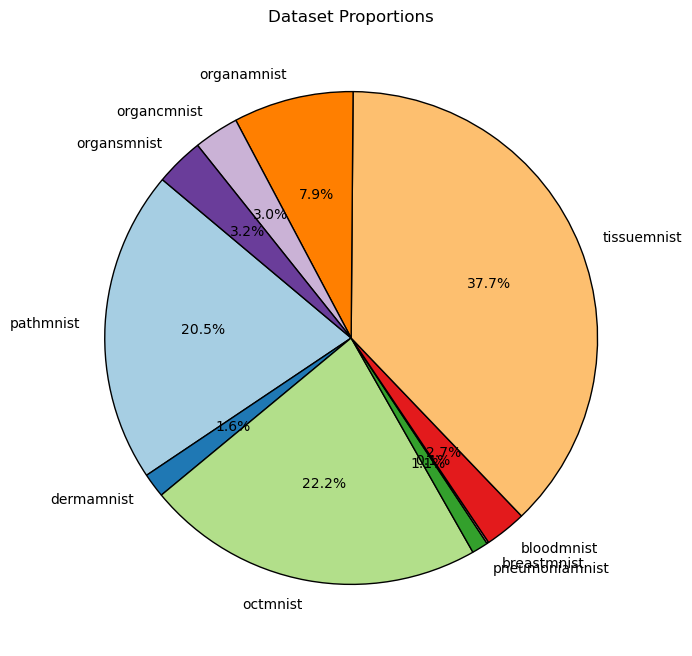

In [8]:
# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(sample_counts, labels=avaliable_datasets, autopct="%1.1f%%", startangle=140, 
        colors=plt.cm.Paired.colors, wedgeprops={"edgecolor": "black"})

# Add a title
plt.title("Dataset Proportions")

# Show the plot
plt.show()

## Data Download

In [9]:
image_size = 28 # 28, 64, 128 or 256
datasets_path = os.path.join(CWD, "datasets", str(image_size))
os.makedirs(datasets_path, exist_ok=True)

md.download(avaliable_datasets, datasets_path, image_size)

File /root/med-mnist/datasets/28/pathmnist_28.npz already exists. Skipping download.
File /root/med-mnist/datasets/28/dermamnist_28.npz already exists. Skipping download.
File /root/med-mnist/datasets/28/octmnist_28.npz already exists. Skipping download.
File /root/med-mnist/datasets/28/pneumoniamnist_28.npz already exists. Skipping download.
File /root/med-mnist/datasets/28/breastmnist_28.npz already exists. Skipping download.
File /root/med-mnist/datasets/28/bloodmnist_28.npz already exists. Skipping download.
File /root/med-mnist/datasets/28/tissuemnist_28.npz already exists. Skipping download.
File /root/med-mnist/datasets/28/organamnist_28.npz already exists. Skipping download.
File /root/med-mnist/datasets/28/organcmnist_28.npz already exists. Skipping download.
File /root/med-mnist/datasets/28/organsmnist_28.npz already exists. Skipping download.


## Dataset Unification

In [10]:
organ_datasets = ["organamnist", "organcmnist", "organsmnist"] # These are the same - have the same classes

md.unify_data(
    organ_datasets,
    are_unique_classes      = False,
    image_size              = image_size,
    datasets_path           = datasets_path,
    save_path               = datasets_path,
    filename                = f"organs_{image_size}"
);

File /root/med-mnist/datasets/28/organs_28.npz already exists.


In [11]:
new_avaliable_datasets = ["organs", "pathmnist", "dermamnist", "octmnist", "pneumoniamnist", \
                            "breastmnist", "bloodmnist", "tissuemnist"]

md.unify_data(
    new_avaliable_datasets,
    are_unique_classes      = True,
    image_size              = image_size,
    datasets_path           = datasets_path,
    save_path               = datasets_path,
    filename                = f"unified_{image_size}"
);

File /root/med-mnist/datasets/28/unified_28.npz already exists.


## Dataset

In [12]:
transform = v2.Compose(
    [
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]
)

# Training augmentations
augmentation = v2.Compose(
    [
        transform,
        v2.RandomHorizontalFlip(p=0.5),
        v2.RandomVerticalFlip(p=0.5),
        v2.Pad(round(image_size/10), padding_mode="reflect"),
        v2.RandomRotation(degrees=20, interpolation=InterpolationMode.BILINEAR),
        v2.CenterCrop(size=(image_size, image_size))
    ]
)

In [13]:
unified_dataset_path = os.path.join(datasets_path, f"unified_{image_size}.npz")

train_dataset = md.NPZDataset(
    unified_dataset_path,
    split       ="train",
    transform   =augmentation,
    mmap_mode   =None
)

validation_dataset = md.NPZDataset(
    unified_dataset_path,
    split       ="val",
    transform   =transform,
    mmap_mode   =None
)

## Data Loader

In [14]:
batch_size = 2048
num_workers = 1

In [15]:
train_loader = DataLoader(
    train_dataset,
    batch_size          =batch_size, 
    shuffle             =True,
    num_workers         =num_workers,
    prefetch_factor     =10,
)

validation_loader = DataLoader(
    validation_dataset,
    batch_size          =batch_size, 
    shuffle             =False,
    num_workers         =num_workers,
    prefetch_factor     =10,
)

### Test Data Loader

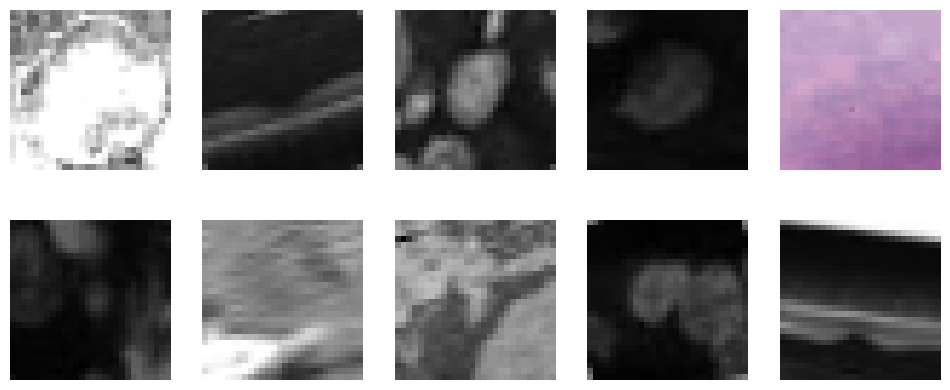

In [16]:
# Get one batch from train_loader
batch = next(iter(train_loader))
images, labels = batch  # Unpack batch

# # Denormalize for visualization
mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)  # Shape (C, 1, 1)
std = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)

# Convert images back to [0, 1] range for visualization
images = images * std + mean  
images = torch.clamp(images, 0, 1)  # Ensure values stay in range

# Plot some images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))  # Grid 2x5
for i, ax in enumerate(axes.flat):
    img = images[i].permute(1, 2, 0).cpu().numpy()  # Convert (C, H, W) → (H, W, C)
    ax.imshow(img)
    ax.axis("off")

plt.show()

# Training

## Parameters

Counts per class: Counter({43: 53075, 30: 46026, 49: 39203, 27: 33484, 50: 24608, 46: 15406, 19: 12885, 6: 12614, 16: 12182, 47: 11789, 14: 10401, 13: 10360, 28: 10213, 12: 9509, 18: 9401, 11: 9366, 15: 8006, 17: 7886, 44: 7814, 29: 7754, 48: 7705, 10: 6689, 9: 6208, 4: 6183, 5: 6106, 45: 5866, 8: 5754, 7: 5662, 25: 4693, 0: 4252, 32: 3494, 3: 2795, 1: 2639, 2: 2566, 41: 2330, 36: 2181, 38: 2026, 42: 1643, 31: 1214, 37: 1085, 40: 993, 35: 852, 39: 849, 24: 779, 22: 769, 34: 399, 21: 359, 20: 228, 33: 147, 26: 99, 23: 80})


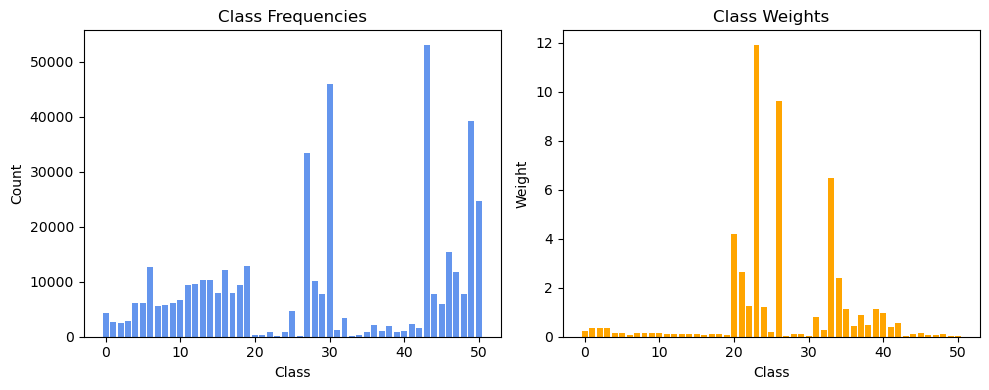

In [17]:
temp_dataset = md.NPZDataset(
    unified_dataset_path,
    split       ="train",
    transform   =transform,
    mmap_mode   ="r"
)

class_weights_tensor = compute_class_weights(temp_dataset, device)

In [ ]:
epochs          =50
arch            ="vit"

optimizer_name  ="AdamW"
lr              =1e-1
momentum        =1
weight_decay    =1e-4
betas           =(0.9, 0.999)
AMSGrad         =True

stat_to_track   ="val_loss" # "loss" "acc" "val_loss" "lr"
mode            ="min" # "min" "max"
patience        =4
delta           =5e-2
delay           = 8

In [ ]:
patch_size      =4
depth           =24
num_heads       =16
mlp_ratio       =32

## Model

In [ ]:
model = VisionTransformer(
    image_size          =image_size,
    patch_size          =patch_size,
    in_channels         =3, 
    num_classes         =51,
    projection_dim      =patch_size*patch_size*3,
    depth               =depth,
    num_heads           =num_heads,
    mlp_ratio           =mlp_ratio,
    dropout             =0.3
)

In [21]:
summary(model, input_size=(batch_size, 3, image_size, image_size))

Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [2048, 51]                2,448
├─PatchEmbedding: 1-1                         [2048, 49, 48]            --
│    └─Patchify: 2-1                          [2048, 49, 48]            --
│    └─Linear: 2-2                            [2048, 49, 48]            2,352
├─Dropout: 1-2                                [2048, 50, 48]            --
├─Sequential: 1-3                             [2048, 50, 48]            --
│    └─TransformerBlock: 2-3                  [2048, 50, 48]            --
│    │    └─LayerNorm: 3-1                    [2048, 50, 48]            96
│    │    └─MultiHeadSelfAttention: 3-2       [2048, 50, 48]            9,408
│    │    └─Dropout: 3-3                      [2048, 50, 48]            --
│    │    └─LayerNorm: 3-4                    [2048, 50, 48]            96
│    │    └─Sequential: 3-5                   [2048, 50, 48]            37,296
│    │ 

In [22]:
!nvidia-smi

Sun Feb 23 20:11:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX 6000 Ada Gene...    On  |   00000000:C1:00.0 Off |                    0 |
| 30%   47C    P2             56W /  300W |    1323MiB /  46068MiB |     23%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [23]:
models_dir_path = os.path.join(CWD, "models")
os.makedirs(models_dir_path, exist_ok=True)

model_save_path = os.path.join(models_dir_path, f"{arch}_d{depth}_h{num_heads}_mlr{mlp_ratio}.pth")

In [ ]:
# Loss function
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Optimizer selection
if optimizer_name == "SGD":
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
elif optimizer_name == "Adam":
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
elif optimizer_name == "AdamW":
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay, beta=betas, AMSGrad=AMSGrad)


# Initialize the scheduler
# Uncomment the scheduler you want to use:
# scheduler = StepLR(optimizer, step_size=5, gamma=0.5)  # Decreases LR by gamma every step_size epochs
scheduler = CosineAnnealingLR(optimizer, T_max=epochs)  # Adjusts LR using cosine annealing over epochs


# Early stopping
stop_fn = EarlyStopping(
    stat_to_track       =stat_to_track,
    mode                =mode,
    patience            =patience,
    delta               =delta,
    delay               =delay,
    save_path           =model_save_path
)

train_loop(
    model,
    criterion           =criterion,
    optimizer           =optimizer,
    scheduler           =scheduler,
    epochs              =epochs,
    train_loader        =train_loader,
    validation_loader   =validation_loader,
    device              =device,
    stop_fn             =stop_fn
)

stopping_report = stop_fn.report()

# If the model was not stopped by EarlyStopping, save it
if not stopping_report:
    torch.save(model.state_dict(), model_save_path)
else:
    for key in stopping_report:
        print(f"{key}: {stopping_report[key]}")

  3/50:  33%|███████████████▏                              | 71/215 [00:49<01:36,  1.49 batch/s, loss=2.063, acc=22.51%]